# **Next Word Predictor**

## Data Preprocessing

In [256]:
# importing required libreries

import tensorflow as tf
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [257]:
# importing data

with open('data.txt', encoding='utf-8') as file:
    data = file.readlines()

In [258]:
# removing all spaces

data = [text for text in data if text!='\n']

In [259]:
# removing punctuations, special charecotors, digits and not ascii charectors from data

pattern="""[!\"#$%&'()*+,-./:;<=>?@[\]\\^_`{|}~]|[0-9]+|[^\u0000-\u007f]+"""
roman_digits = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']

def text_preprocessing(text):
    text = re.sub(pattern = pattern, repl= "", string=text)
    for i in text:
        if i in roman_digits:
            i = ""
            text = "".join(i)


    return text.strip().lower()     

In [260]:
# applying preprocessing

filtered_data = []

for text in data:
    filtered_data.append(text_preprocessing(text))

In [261]:
# removing single words in list

filtered_data = [" ".join(text.split()) for text in filtered_data if len(text.split())>1]
filtered_data

['project gutenbergs the adventures of sherlock holmes by arthur conan doyle',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever you may copy it give it away or',
 'reuse it under the terms of the project gutenberg license included',
 'with this ebook or online at wwwgutenbergnet',
 'title the adventures of sherlock holmes',
 'author arthur conan doyle',
 'release date november ebook',
 'last updated may',
 'language english',
 'character set encoding utf',
 'produced by an anonymous project gutenberg volunteer and jose menendez',
 'the adventures of sherlock holmes',
 'by arthur conan doyle',
 'were abhorrent to his cold precise but admirably balanced mind he',
 'the world has seen but as a lover he would have placed himself in a',
 'false position he never spoke of the softer passions save with a gibe',
 'and a sneer they were admirable things for the observerexcellent for',
 'drawing the veil from mens motives and actions but fo

In [262]:
# creating a single paragraph

input_data = " ".join(filtered_data)

In [263]:
# checking for input data

input_data

'project gutenbergs the adventures of sherlock holmes by arthur conan doyle this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away or reuse it under the terms of the project gutenberg license included with this ebook or online at wwwgutenbergnet title the adventures of sherlock holmes author arthur conan doyle release date november ebook last updated may language english character set encoding utf produced by an anonymous project gutenberg volunteer and jose menendez the adventures of sherlock holmes by arthur conan doyle were abhorrent to his cold precise but admirably balanced mind he the world has seen but as a lover he would have placed himself in a false position he never spoke of the softer passions save with a gibe and a sneer they were admirable things for the observerexcellent for drawing the veil from mens motives and actions but for the trained reasoner to admit such intrusions into his own delicate and

In [264]:
# tokenizing data

tokenizer = Tokenizer()
tokenizer.fit_on_texts([input_data])

In [265]:
# checking length of corpus

len(tokenizer.word_index)

7319

In [266]:
# checking for a single text

text = filtered_data[0]
print(text.split())
print(tokenizer.texts_to_sequences([text])[0])
tokenizer.word_index['conan']


['project', 'gutenbergs', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle']
[102, 3681, 1, 987, 3, 106, 33, 40, 484, 1577, 1578]


1577

## Model Building 

In [267]:
# creating input sequence to feed in model

input_seq = []

for text in filtered_data:
    text = tokenizer.texts_to_sequences([text])[0]
    for i in range(1, len(text)):
        input_seq.append(text[:i+1])

In [268]:
# input sequence

input_seq

[[102, 3681],
 [102, 3681, 1],
 [102, 3681, 1, 987],
 [102, 3681, 1, 987, 3],
 [102, 3681, 1, 987, 3, 106],
 [102, 3681, 1, 987, 3, 106, 33],
 [102, 3681, 1, 987, 3, 106, 33, 40],
 [102, 3681, 1, 987, 3, 106, 33, 40, 484],
 [102, 3681, 1, 987, 3, 106, 33, 40, 484, 1577],
 [102, 3681, 1, 987, 3, 106, 33, 40, 484, 1577, 1578],
 [27, 873],
 [27, 873, 13],
 [27, 873, 13, 19],
 [27, 873, 13, 19, 1],
 [27, 873, 13, 19, 1, 238],
 [27, 873, 13, 19, 1, 238, 3],
 [27, 873, 13, 19, 1, 238, 3, 319],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579, 17],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579, 17, 46],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579, 17, 46, 1317],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579, 17, 46, 1317, 2],
 [27, 873, 13, 19, 1, 238, 3, 319, 1579, 17, 46, 1317, 2, 14],
 [485, 46],
 [485, 46, 2516],
 [485, 46, 2516, 2517],
 [485, 46, 2516, 2517, 9],
 [485, 46, 2516, 2517, 9, 74],
 [485, 46, 2516, 2517, 9, 74, 600],
 [485, 46, 2516, 2517, 9, 74, 600, 12],
 [4

In [269]:
# checking for input sequnce having maximum length

max_len = max([len(x) for x in input_seq])
max_len

18

In [270]:
# applying pre padding to input sequence

input_seq = pad_sequences(input_seq, maxlen=max_len, padding='pre')
input_seq

array([[   0,    0,    0, ...,    0,  102, 3681],
       [   0,    0,    0, ...,  102, 3681,    1],
       [   0,    0,    0, ..., 3681,    1,  987],
       ...,
       [   0,    0,    0, ...,    5,  478,   76],
       [   0,    0,    0, ...,  478,   76,  346],
       [   0,    0,    0, ...,   76,  346, 1313]])

In [271]:
# splitting data into X and y

X = input_seq[:, :-1]
y = input_seq[:, -1]

In [272]:
# converting target variable into categorical variable 
# doing one hot encoding on target variable 

y = to_categorical(y, num_classes=7320)

In [273]:
# Model architecture

model = Sequential()

model.add(Embedding(7320, 100, input_length=17))
model.add(LSTM(150, kernel_regularizer=l2(0.001)))
model.add(Dense(7320, activation='softmax'))

In [274]:
# model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 17, 100)           732000    
                                                                 
 lstm_2 (LSTM)               (None, 150)               150600    
                                                                 
 dense_2 (Dense)             (None, 7320)              1105320   
                                                                 
Total params: 1987920 (7.58 MB)
Trainable params: 1987920 (7.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [275]:
# compiling model

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [276]:
# training model and storing logs in hist variable

hist = model.fit(X, y, validation_split=0.2, batch_size=64, epochs=20)

Epoch 1/20
777/777 [==============================] - 25s 28ms/step - loss: 6.6342 - accuracy: 0.0660 - val_loss: 6.7088 - val_accuracy: 0.0699
Epoch 2/20
777/777 [==============================] - 21s 28ms/step - loss: 6.1582 - accuracy: 0.0783 - val_loss: 6.6798 - val_accuracy: 0.0741
Epoch 3/20
777/777 [==============================] - 20s 26ms/step - loss: 5.9595 - accuracy: 0.0869 - val_loss: 6.6513 - val_accuracy: 0.0873
Epoch 4/20
777/777 [==============================] - 21s 27ms/step - loss: 5.7485 - accuracy: 0.1024 - val_loss: 6.6000 - val_accuracy: 0.0963
Epoch 5/20
777/777 [==============================] - 19s 24ms/step - loss: 5.5634 - accuracy: 0.1129 - val_loss: 6.6284 - val_accuracy: 0.1004
Epoch 6/20
777/777 [==============================] - 19s 24ms/step - loss: 5.3853 - accuracy: 0.1227 - val_loss: 6.6527 - val_accuracy: 0.1064
Epoch 7/20
777/777 [==============================] - 19s 24ms/step - loss: 5.2142 - accuracy: 0.1342 - val_loss: 6.7098 - val_accuracy:

## Model Evaluations

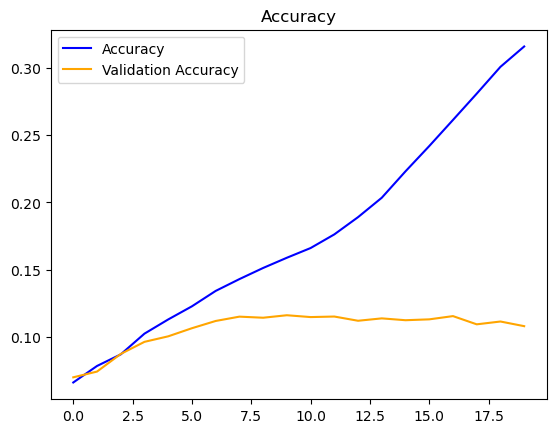

In [282]:
# Plotting accuracy curve

plt.plot(hist.history['accuracy'], color='blue', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

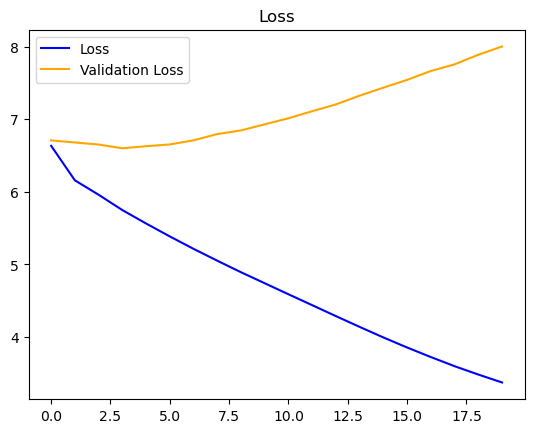

In [283]:
# plotting loss curve

plt.plot(hist.history['loss'], color='blue', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Making Predictions

In [286]:
# making predictions

import time
text = "To Sherlock Holmes"

for i in range(10):
  # tokenize
  token_text = tokenizer.texts_to_sequences([text])[0]
  # padding
  padded_token_text = pad_sequences([token_text], maxlen=17, padding='pre')
  # predict
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

1/1 [==============================] - 0s 48ms/step
To Sherlock Holmes he
1/1 [==============================] - 0s 18ms/step
To Sherlock Holmes he was
1/1 [==============================] - 0s 31ms/step
To Sherlock Holmes he was a
1/1 [==============================] - 0s 31ms/step
To Sherlock Holmes he was a little
1/1 [==============================] - 0s 31ms/step
To Sherlock Holmes he was a little man
1/1 [==============================] - 0s 25ms/step
To Sherlock Holmes he was a little man and
1/1 [==============================] - 0s 27ms/step
To Sherlock Holmes he was a little man and he
1/1 [==============================] - 0s 30ms/step
To Sherlock Holmes he was a little man and he was
1/1 [==============================] - 0s 29ms/step
To Sherlock Holmes he was a little man and he was a
1/1 [==============================] - 0s 28ms/step
To Sherlock Holmes he was a little man and he was a solicitor
